# ExprOptimization.jl

ExprOptimization.jl is a Julia package for optimizing Julia expressions.  The package implements algorithms to optimize expression trees derived from a grammar to optimize a user-defined objective function.  The package depends on ExprRules.jl.

## Installation

To install the package:

    Pkg.add("ExprOptimization")

## Usage

To start using the package:

In [1]:
using ExprOptimization


## Example -- Approximation of π

We consider the example of finding an algebraic expression that approximates pi using only functions from a four function calculator.

First, we define a grammar:

In [2]:
const grammar = @grammar begin
    R = |(1:9)
    R = R + R
    R = R - R
    R = R * R
    R = R / R
end

1: R = 1
2: R = 2
3: R = 3
4: R = 4
5: R = 5
6: R = 6
7: R = 7
8: R = 8
9: R = 9
10: R = R + R
11: R = R - R
12: R = R * R
13: R = R / R


In [3]:
const S = SymbolTable(grammar)

Dict{Symbol,Any} with 4 entries:
  :+ => +
  :/ => /
  :- => -
  :* => *

Next, we define the loss function by overloading the `loss` function in ExprOptimization.  The loss function returns the real-valued loss of a given expression tree.  The loss is minimized.

In [4]:
function loss(tree::RuleNode, grammar::Grammar)
    ex = get_executable(tree, grammar)
    value = Core.eval(S, ex)
    if isinf(value) || isnan(value)
        return Inf
    end
    Δ = abs(value - π)
    return log(Δ) + length(tree) / 1e4
end

loss (generic function with 1 method)

Once these are defined, we can use any of the implemented algorithms to perform the optimization.

### Monte Carlo

Monte Carlo (MC) draws a number of random expression trees from the grammar and returns the one with the best loss.

In [5]:
?MonteCarlo

search: MonteCarlo MonteCarlos



```
MonteCarlo
```

Monte Carlo.

# Arguments:

  * `num_samples::Int`: number of samples
  * `max_depth::Int`: maximum depth of derivation tree


In [6]:
using Random
Random.seed!(3)
p = MonteCarlo(50000, 8)
results_mc = optimize(p, grammar, :R, loss)
(expr, val, err) = (results_mc.expr, Core.eval(Main,results_mc.expr), abs(Core.eval(Main,results_mc.expr)-π))

(:(3 + (((5 - 1) / 1 - 2) / 5) / (1 * (6 / (7 - 5)))), 3.1333333333333333, 0.008259320256459812)

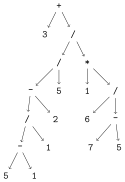

In [7]:
display(results_mc.tree, grammar)

## Genetic Programming

Genetic Programming (GP) is an evolutionary algorithm for trees.

See: Koza, "Genetic Programming: On the Programming of Computers by Means of Natural Selection", MIT Press, 1992.

In [8]:
?GeneticProgram

search: GeneticProgram GeneticPrograms



```
GeneticProgram
```

Genetic Programming.

# Arguments

  * `pop_size::Int`: population size
  * `iterations::Int`: number of iterations
  * `max_depth::Int`: maximum depth of derivation tree
  * `p_reproduction::Float64`: probability of reproduction operator
  * `p_crossover::Float64`: probability of crossover operator
  * `p_mutation::Float64`: probability of mutation operator
  * `init_method::InitializationMethod`: initialization method
  * `select_method::SelectionMethod`: selection method


In [9]:
Random.seed!(3)
p = GeneticProgram(1000,50,8,0.2,0.4,0.4; select_method=GeneticPrograms.TruncationSelection(100))
results_gp = optimize(p, grammar, :R, loss)
(expr, val, err) = (results_gp.expr, eval(results_gp.expr), abs(eval(results_gp.expr)-π))

(:(4 - 8 / (9 + 3 / (9 + (1 + 1 / 6) / 3))), 3.1415873015873013, 5.35200249185408e-6)

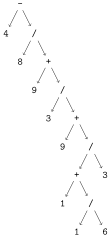

In [10]:
display(results_gp.tree, grammar)

## Grammatical Evolution

Grammatical Evolution (GE) is an evolutionary algorithm based on sequentializing the decisions in the derivation tree (e.g., using depth-first traversal order).  Optimization is performed over integer arrays using genetic algorithms.

See: C. Ryan, J.J. Collins, M. O'Neil, "Grammatical Evolution: Evolving Programs for an Arbitrary Language", in European Conference on Genetic Programming, Springer, 1998, pp. 83-96.

In [11]:
?GrammaticalEvolution

search: GrammaticalEvolution GrammaticalEvolutions



```
GrammaticalEvolution
```

Grammatical Evolution.

# Arguments

  * `grammar::Grammar`: grammar
  * `typ::Symbol`: start symbol
  * `pop_size::Int`: population size
  * `iterations::Int`: number of iterations
  * `init_gene_length::Int`: initial length of genotype integer array
  * `max_gene_length::Int`: maximum length of genotype integer array
  * `max_depth::Int`: maximum depth of derivation tree
  * `p_reproduction::Float64`: probability of reproduction operator
  * `p_crossover::Float64`: probability of crossover operator
  * `p_mutation::Float64`: probability of mutation operator
  * `select_method::SelectionMethod`: selection method (default: tournament selection)
  * `mutate_method::InitializationMethod`: mutation method (default: multi-mutate)


In [12]:
Random.seed!(4)
p = GrammaticalEvolution(grammar,:R,1000,50,20,20,8,0.2,0.4,0.4; select_method=GrammaticalEvolutions.TruncationSelection(100))
results_ge = optimize(p, grammar, :R, loss)
(expr, val, err) = (results_ge.expr, eval(results_ge.expr), abs(eval(results_ge.expr)-π))

(:(((9 / 4) * 7) / 5), 3.15, 0.008407346410206795)

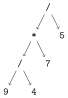

In [13]:
display(results_ge.tree, grammar)

## Cross-Entropy Method

The Cross-Entropy (CE) Method is a population-based optimization algorithm based on repeatedly estimating the probability distribution of good solutions.  This implementation uses a probabilistic grammar to represent the distributions.

See: Rubinstein, "Optimization of Computer Simulation Models with Rare Events", European Journal of Operations Research, 99, 89-112, 1197

In [14]:
?CrossEntropy

search: CrossEntropy CrossEntropys



```
CrossEntropy
```

Cross Entropy method.

# Arguments

  * `pop_size::Int`: population size
  * `iterations::Int`: number of iterations
  * `max_depth::Int`: maximum depth of derivation tree
  * `top_k::Int`: top k elite samples used in selection
  * `p_init::Float64`: initial value when fitting MLE
  * `init_method::InitializationMethod`: Initialization method


In [15]:
Random.seed!(0)
p = CrossEntropy(1000,50,8,500,0.0)
results_ce = optimize(p, grammar, :R, loss)
(expr, val, err) = (results_ce.expr, eval(results_ce.expr), abs(eval(results_ce.expr)-π))

(:((1 - ((2 + 9 * (7 / 8 + (5 / 5 - 2))) + 1)) + 4), 3.125, 0.016592653589793116)

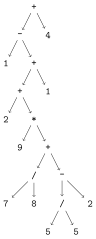

In [16]:
display(results_ce.tree, grammar)

## PIPE

Probabilistic Incremental Program Evolution (PIPE) is an expression tree optimization algorithm based on the probabilistic prototype tree (PPT) model.

See: Salustowicz and Schmidhuber, "Probabilistic Incremental Program Evolution", Evolutionary Computation, vol. 5, no. 2, pp. 123-141, 1997.

In [17]:
?PIPE

search: PIPE PIPEs Pipe pipeline PipeBuffer partialsortperm partialsortperm!



```
PIPE
```

Probabilistic Incremental Program Evolution. Example parameters from paper are indicated in parentheses)

# Arguments:

  * `ppt_params::PPT`: parameters for PPT  (e.g., [0.8, 0.2])
  * `pop_size::Int`: population size
  * `iterations::Int`: number of iterations
  * `p_elitist::Float64`: elitist update probability (e.g., 0.2)
  * `c::Float64`: learning rate multiplier (e.g., 0.1)
  * `α::Float64`: learning rate (e.g., 0.05)
  * `ϵ::Float64`: fitness constant (e.g., 1)
  * `p_mutation::Float64`: mutation probability (e.g., 0.2)
  * `β::Float64`: mutation rate (e.g., 0.6)
  * `p_threshold::Float64`: prune threshold (e.g., 0.999)
  * `max_depth::Int`: maximum depth of derivation tree


In [18]:
Random.seed!(4)
p = PIPE(PPT(0.8),5000,80,0.2,0.1,0.05,1,0.2,0.6,0.999,8)
results_pipe = optimize(p, grammar, :R, loss)
(expr, val, err) = (results_pipe.expr, eval(results_pipe.expr), abs(eval(results_pipe.expr)-π))

(:((9 - ((2 - 9) - 6)) / 7), 3.142857142857143, 0.0012644892673496777)

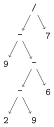

In [19]:
display(results_pipe.tree, grammar)